<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/22.00.Aula-Construindo_Cenarios_Distribuicao_Idades.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelo individual: incluindo a fase de exposição](21.00.Aula-Modelo_individual_infeccao_e_recuperacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: rede de empresas ->](23.00.Aula-Cenario_Rio_Empresas.ipynb)

---


# Construção de cenários: definindo as idades

- O objetivo, aqui, é definir as idades de cada indivíduo da população.

- Isso será feito após a alocação dos indivíduos em residências.

- Como exemplo, vamos usar a rede de residências de uma fração da população do Rio de Janeiro.

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy.stats import zipf

import networkx as nx

from numba import jit, njit, prange
from numba.typed import List
import threading # for multi-threading with numba.jit

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jun/2020


## Distribuição espacial da população da cidade do Rio de Janeiro

### Carregando os dados

Os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro foram obtidos pelo [Landscan](https://landscan.ornl.gov).

Como feito anteriormente, após carregarmos os dados, zeramos os valores das células com -1, que indicam falta de informação.

In [5]:
landscan_rio = np.maximum(np.load('../input/dados_rio/landscan_rio.npy').astype(int), 0)

### Reduzindo a população para testes

Na montagem do cenário, com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator.

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [6]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 67973


### Visualização da distribuição populacional em escala logarítmica

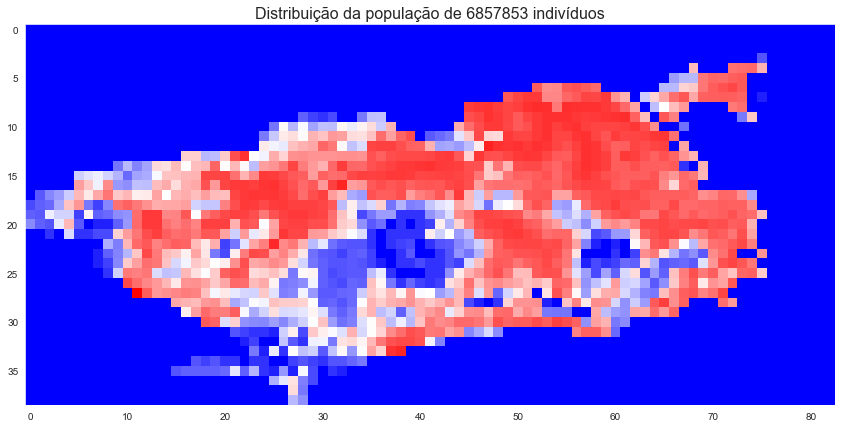

In [7]:
plt.figure(figsize=(15,7))
plt.imshow(np.log(1 + landscan_rio), cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Censo residencial

A distribuição da população em residências é feita segundo um censo com a porcentagem de residências por número de residentes:

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])

### Distribuindo e alocando os indivíduos e as suas residências

In [9]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 1.03 s, sys: 28 ms, total: 1.05 s
Wall time: 1.22 s


### Distribuição por tamanho de residência

In [10]:
num_tam_res = len(censo_residencial)
distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])

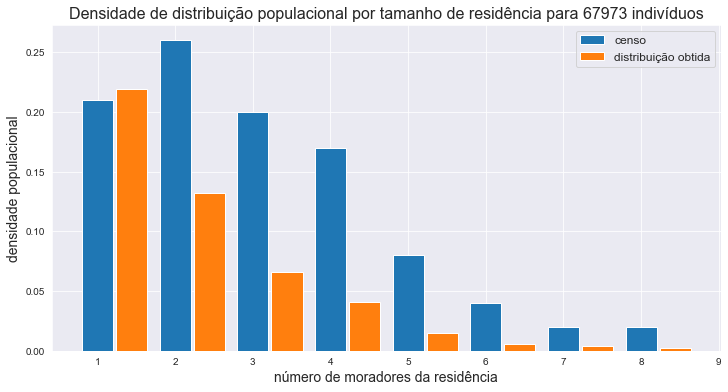

In [11]:
plt.figure(figsize=(12,6))
bar_width = 0.4
r1 = [j for j in range(1,num_tam_res+1)]
r2 = [j + 1.1*bar_width for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width, label='censo')
plt.bar(r2, distrib_res/num_pop, width=bar_width, label=f'distribuição obtida')
plt.xlabel('número de moradores da residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Densidade de distribuição populacional por tamanho de residência para {num_pop} indivíduos',
          fontsize=16)
plt.show()  

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), que infelizemente não diferencia faixas acima de 65 anos:


| Total | 100,0 |
| --- | --- |
| 0 a 4 anos | 9,4 |
| 5 a 9 anos | 11,9 |
| 10 a 13 anos | 13,2 |
| 14 a 17 anos | 15,5 |
| 18 e 19 anos | 14,2 |
| 20 a 24 anos | 14,0 |
| 25 a 29 | 22,0 |
| 30 a 39 anos | 15,5 |
| 40 a 49 anos | 14,2 |
| 50 a 59 anos | 14,0 |
| 60 a 64 anos | 14,0 |
| 65 ou mais | 22,0 |



###  Tabelando os dados disponíveis

Primeiramente montamos duas listas, umas com as faixas etárias e outra com a fração da população em cada faixa.

In [12]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


### Visualizando a pirâmide

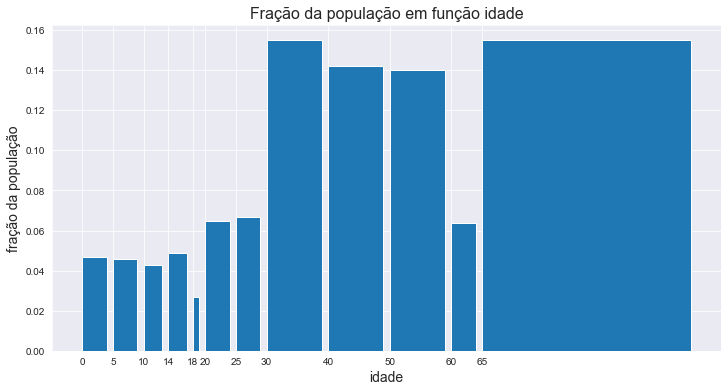

In [13]:
plt.figure(figsize=(12,6))
bar_width = [idades_grupos[j+1] - idades_grupos[j] - 1 for j in range(len(idades_grupos)-1)] \
            + [idade_max - idades_grupos[-1] -1]
plt.bar(idades_grupos, idades_fracoes_grupos, width=bar_width, align='edge')
plt.xticks(idades_grupos)
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

### Interpolando e extrapolando os dados

Agora, interpolamos os dados para ter frações para cada idade na faixas acima e extrapolamos no caso da última faixa.

Vou fazer uma interpolação/extrapolação simples, de maneira constante por partes, mas podemos melhorar isso, principalmente usando o número de nascidos na faixa de 0 a 1 ano e frações para idades maiores.

In [14]:
idades_fracoes = list()
for j in range(len(idades_grupos)-1):
    idades_fracoes += (idades_grupos[j+1] - idades_grupos[j]) \
        * [idades_fracoes_grupos[j]/(idades_grupos[j+1]-idades_grupos[j])]

idades_fracoes += (idade_max - idades_grupos[-1]) \
        * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]

idades_fracoes = np.array(idades_fracoes)
print(idades_fracoes.sum())

1.0000000000000002


### Visualizando a pirâmide

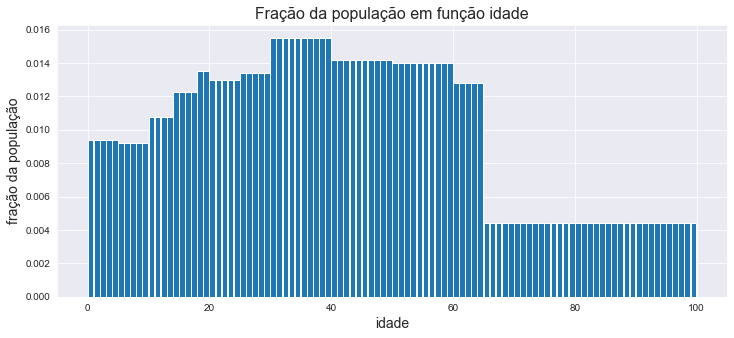

In [15]:
plt.figure(figsize=(12,5))
plt.bar(range(len(idades_fracoes)), idades_fracoes, width=0.95, align='edge')
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Fração da população em função idade', fontsize=16)
plt.show()

## Distribuição das idades dos indivíduos

- A estratégia é usar os dados da pirâmide populacional do Rio de Janeiro como pesos nas escolhas das idades dos indivíduos.

- Vamos fazer por partes, percorrendo as residências por tamanho e sorteando as idades dos residentes;

    - Nas casas com um único indivíduo, sorteamos um adulto (20 anos para cima), com pesos proporcionais as faixas de 20 pra cima.
    
    - Nas casas com dois indivíduos, sorteamos 90% deles com dois adultos e 10% deles com um adulto e uma criança
    
    - Nas casas com mais de dois indivíduos, sorteamos dois adultos e o restante de qualquer idade
    
    - A cada passo, atualizamos a população restante para obter novos pesos.

### Distribuindo as idades

- Primeiro, consideramos a população em idade ativa.

- De acordo com o IBGE, a população em idade ativa é formada pelos indivíduos com 16 ou mais anos de idade.

- Segundo, consideramos a parte economicamente ativa, que são os, de fato, trabalhando de alguma forma. Nesse caso:

    - Boa parte dos que têm até 17 ou 18 anos ainda está no ensino médio.

    - Uma certa parte dos que têm em torno de vinte anos está na faculdade.
    
    - Boa parte dos que têm 60 anos ou mais está aposentada.
    
    - Uma parte razoável dos outros está desocupada.
    

- Na falta de dados concretos, vou assumir certas frações das populações dessas idades como estando economicamente ativas, para serem alocadas nos locais de trabalho.

### Separa as residências por tamanho

In [16]:
%%time
res = (num_tam_res+1)*[[]]
for j in range(1,num_tam_res+1):
    res[j] = [r for r in res_individuos if len(r) == j]
res_2b = random.sample(res[2], k=int(0.1*len(res[2])))
res_2a = [r for r in res[2] if r not in res_2b]
res_3mais = []
for res_k in res[3:]:
    res_3mais += res_k

CPU times: user 487 ms, sys: 5.81 ms, total: 493 ms
Wall time: 500 ms


### Separa a piramide populacional em crianças/jovens e adultos

As distribuições são apenas para definir os pesos para as escolhas das idades, não sendo estritamente necessário transformá-los em inteiros cuja soma dê exatamente a população total.

In [17]:
idades = list(range(len(idades_fracoes)))

distrib_idades_adultos = num_pop*idades_fracoes
distrib_idades_adultos[:20] = 0

distrib_idades_menores = num_pop*idades_fracoes
distrib_idades_menores[20:] = 0

### Visualizando

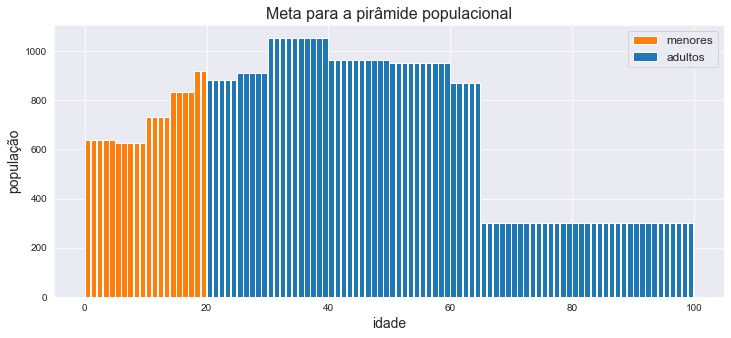

In [18]:
plt.figure(figsize=(12,5))
plt.bar(range(len(distrib_idades_menores)), distrib_idades_menores,
        width=0.9, align='edge', color='tab:orange', label='menores')
plt.bar(range(len(distrib_idades_adultos)), distrib_idades_adultos,
        width=0.9, align='edge', color='tab:blue', label='adultos')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Meta para a pirâmide populacional', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Inicializa a lista de idades dos indivíduos

In [19]:
pop_idades = np.zeros(num_pop).astype(int)
n = 0

In [20]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 0
Distribuição de indivíduos em função da idade:
[67973     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


### Define a idade dos adultos morando sozinhos

Colocamos um adulto nas residências que contém apenas um indivíduo.

In [21]:
%%time
random.seed(17000001)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res[1]))
for j in range(len(res[1])):
    pop_idades[res[1][j]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res[1])
print(len(res[1]))
print(n)

14886
14886
CPU times: user 75.3 ms, sys: 2.05 ms, total: 77.4 ms
Wall time: 78.4 ms


In [22]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 14886
Distribuição de indivíduos em função da idade:
[53087     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   244   236   244   229
   241   254   241   265   245   245   293   307   310   276   277   307
   286   281   308   311   253   251   281   267   275   277   309   265
   268   282   279   299   261   229   250   274   275   273   253   257
   245   249   237   233   238    72    83    85    86    66    77    95
    95    83    97    73    69    67    81    90    80    71    81    86
    95    78    75    77    89   105   105    86   102    92    93    68
    62    85    87    70]


### Define a idade do único adulto em residências com um adulto e um menor

In [23]:
%%time
random.seed(27000002)

ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_2b))
for j in range(len(res_2b)):
    pop_idades[res_2b[j][0]] = ind_idades[j]
    distrib_idades_adultos[ind_idades[j]] -= 1
n += len(res_2b)
print(len(res_2b))
print(n)

895
15781
CPU times: user 3.1 ms, sys: 648 µs, total: 3.75 ms
Wall time: 3.33 ms


In [24]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 15781
Distribuição de indivíduos em função da idade:
[52192     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   265   247   263   250
   251   266   263   277   263   260   314   327   328   298   295   323
   311   297   323   327   274   265   299   289   286   291   327   279
   280   296   291   318   277   247   270   292   287   291   268   266
   262   261   249   248   248    74    90    91    90    71    87   103
   101    90   103    77    71    75    84    95    84    78    84    92
    97    84    77    83    91   107   112    89   105    95    96    71
    65    92    93    75]


### Define a idade de dois adultos nas outras residências com dois indivíduos

- Nas residêcias com apenas dois indivíduos, já colocamos, anteriormente, um adulto nas residências com uma adulto e um menor. Agora, colocamos dois adultos no restante das residências com dois indivíduos.

In [25]:
%%time
random.seed(37010203)
len_res_2a = len(res_2a)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_2a)
for j in range(len_res_2a):
    pop_idades[res_2a[j][0]] = ind_idades[j]
    pop_idades[res_2a[j][1]] = ind_idades[len_res_2a + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_2a + j]] -= 1
n += 2*len_res_2a
print(f'Alocados nesta etapa: {2*len_res_2a}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 16118
Alocados até o momento: 31899
CPU times: user 44.3 ms, sys: 2.32 ms, total: 46.6 ms
Wall time: 49.9 ms


In [26]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 31899
Distribuição de indivíduos em função da idade:
[36074     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   516   522   547   545
   499   532   557   545   516   560   632   641   634   607   616   649
   633   623   639   633   537   571   565   552   562   574   594   561
   559   630   578   591   577   548   529   595   593   577   573   568
   481   502   507   521   529   172   196   172   184   176   172   183
   187   186   185   170   171   171   163   183   179   162   176   181
   164   187   179   176   190   191   198   185   189   177   176   180
   168   179   188   183]


### Define a idade de dois adultos nas residências com três ou mais indivíduos

In [27]:
%%time
random.seed(47010204)
len_res_3mais = len(res_3mais)
ind_idades = random.choices(idades, distrib_idades_adultos, k=2*len_res_3mais)
for j in range(len_res_3mais):
    pop_idades[res_3mais[j][0]] = ind_idades[j]
    pop_idades[res_3mais[j][1]] = ind_idades[len_res_3mais + j]
    distrib_idades_adultos[ind_idades[j]] -= 1
    distrib_idades_adultos[ind_idades[len_res_3mais + j]] -= 1
n += 2*len_res_3mais
print(f'Alocados nesta etapa: {2*len_res_3mais}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 18200
Alocados até o momento: 50099
CPU times: user 49.5 ms, sys: 2.72 ms, total: 52.2 ms
Wall time: 55.6 ms


In [28]:
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

Total do histograma: 67973
Total de alocados com um ano ou mais: 50099
Distribuição de indivíduos em função da idade:
[17874     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   858   849   838   827
   806   850   855   870   852   838   953  1011   965   975   981   985
  1003  1012  1004   977   900   921   900   894   922   902   902   881
   924   934   851   873   859   877   891   880   920   880   878   912
   827   797   829   801   847   282   276   271   294   278   262   294
   273   281   290   287   281   282   271   267   262   271   293   274
   278   282   298   272   275   284   293   287   284   255   300   274
   283   279   273   282]


### Define a idade dos menores de idade em residências com um adulto e um menor

In [29]:
%%time
random.seed(57010205)
len_res_2b = len(res_2b)
ind_idades = random.choices(idades, distrib_idades_menores, k=len_res_2b)
for j in range(len_res_2b):
    pop_idades[res_2b[j][1]] = ind_idades[j]
    distrib_idades_menores[ind_idades[j]] -= 1
n += len_res_2b
print(f'Alocados nesta etapa: {len_res_2b}')
print(f'Alocados até o momento: {n}')

Alocados nesta etapa: 895
Alocados até o momento: 50994
CPU times: user 5.05 ms, sys: 1.16 ms, total: 6.21 ms
Wall time: 8.47 ms


### Calcula a distribuição restante de idades

In [30]:
distrib_idades_left = np.array([distrib_idades_menores[j] \
                                + distrib_idades_adultos[j] for j in range(len(idades_fracoes))])
print(distrib_idades_left.astype(int))

[595 599 602 609 602 580 588 578 585 585 665 684 705 684 775 777 784 792
 858 855  25  34  45  56  77  60  55  40  58  72 100  42  88  78  72  68
  50  41  49  76  65  44  65  71  43  63  63  84  41  31 100  78  92  74
  60  71  31  71  73  39  43  73  41  69  23  19  25  30   7  23  39   7
  28  20  11  14  20  19  30  34  39  30   8  27  23  19   3  29  26  17
   8  14  17  46   1  27  18  22  28  19]


### Verifica histograma até o momento

In [31]:
print(f'População total: {num_pop}')
print(f'Alocados até o mometo: {n}')
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
pop_idades_hist_1up = np.array([len(pop_idades[pop_idades==j]) for j in range(1,100)])
print(f'Total do histograma: {pop_idades_hist.sum()}')
print(f'Total de alocados com um ano ou mais: {pop_idades_hist_1up.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

População total: 67973
Alocados até o mometo: 50994
Total do histograma: 67973
Total de alocados com um ano ou mais: 50951
Distribuição de indivíduos em função da idade:
[17022    39    36    29    36    45    37    47    40    40    65    46
    25    46    57    55    48    40    59    62   858   849   838   827
   806   850   855   870   852   838   953  1011   965   975   981   985
  1003  1012  1004   977   900   921   900   894   922   902   902   881
   924   934   851   873   859   877   891   880   920   880   878   912
   827   797   829   801   847   282   276   271   294   278   262   294
   273   281   290   287   281   282   271   267   262   271   293   274
   278   282   298   272   275   284   293   287   284   255   300   274
   283   279   273   282]


### Define a idade do restante dos invidívuos em residências de três ou mais indivíduos

In [32]:
%%time
for k in range(3,num_tam_res+1):
    ind_idades = random.choices(idades, distrib_idades_left, k=(k-2)*len(res[k]))
    for j in range(len(res[k])):
        for l in range(2, k):
            pop_idades[res[k][j][l]] = ind_idades[(l-2)*len(res[k]) + j]
            distrib_idades_left[ind_idades[(l-2)*len(res[k]) + j]] -= 1
    n += (k-2)*len(res[k])
#print(f'Alocados nesta etapa: {len_res_2b}')
print(f'Alocados até o momento: {n}')

Alocados até o momento: 67973
CPU times: user 60.7 ms, sys: 2.91 ms, total: 63.6 ms
Wall time: 70.7 ms


### Conferindo

In [33]:
print(f'População total: {num_pop}')
print(f'Alocados ao final: {n}')
pop_idades_hist = np.array([len(pop_idades[pop_idades==j]) for j in range(100)])
print(f'Total de alocados via somatório do histograma: {pop_idades_hist.sum()}')
print(f'Distribuição de indivíduos em função da idade:\n{pop_idades_hist}')

População total: 67973
Alocados ao final: 67973
Total de alocados via somatório do histograma: 67973
Distribuição de indivíduos em função da idade:
[ 640  637  642  634  636  627  612  626  620  629  730  734  742  736
  832  832  835  836  913  914  884  884  882  885  885  907  908  911
  910  914 1052 1055 1054 1052 1052 1051 1058 1055 1050 1055  966  965
  965  967  963  967  966  963  965  965  954  953  951  953  952  949
  952  949  955  952  869  869  870  868  869  301  301  305  301  301
  302  301  299  303  301  300  302  303  301  299  303  301  301  300
  301  299  302  301  300  302  299  300  302  304  301  301  302  305
  301  300]


### Visualizando

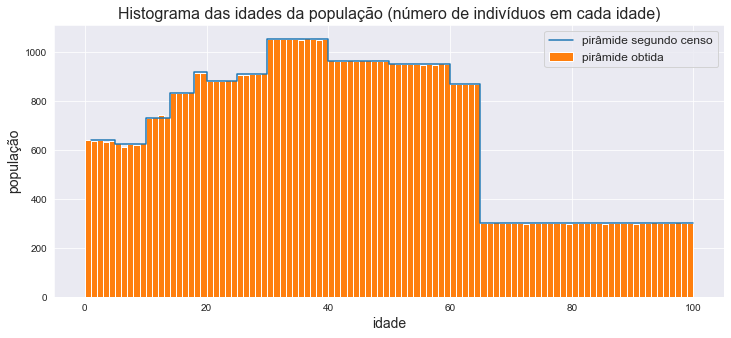

In [34]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(101)), color='tab:orange', label='pirâmide obtida')
plt.step([i+1 for i in idades],num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title('Histograma das idades da população (número de indivíduos em cada idade)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Aplicando em outras frações da população do Rio

- O código acima foi implementado no módulo de simulação em uma função chamada `gera_idades`.

    - Essa função recebe os argumentos

        - `num_pop` (inteiro indicando a população total);
        - `num_tam_res` (inteiro positivo indicando o maior tamanho possível para as residências);
        - `res_individuos` (lista de listas, com o índice de indivíduos em cada residência);
        - `idades_fracoes` (lista de pontos flutuantes com as frações da população para cada ano de vida)

    - Retornando

        - `pop_idades` (lista de inteiros, com a idade de cada indivíduo).

- O argumento `idades_fracoes` pode ser obtido através da função `obtem_idades_fracoes`, com os seguintes dados obtidos, tipicamente, de uma pirâmide etária:

    - `idades_grupos` (as faixas de idades da pirâmide etária);
    - `idades_fracoes_grupos` (as frações da população em cada faixa etária);
    - `idade_max` (a idade máxima considerada para a população; default 100).

- Vamos usar essas funções para definir as idades em outras frações da população do Rio de Janeiro.

### Pirâmide populacional

Vamos considerar os seguintes dados da pirâmide populacional, como feito acima.

In [35]:
idades_grupos = np.array([0, 5, 10, 14, 18, 20, 25, 30, 40, 50, 60, 65])
idades_fracoes_grupos = np.array([0.047, 0.046, 0.043, 0.049, 0.027, 0.065, 0.067, 0.155, 0.142,
                                  0.140, 0.064, 0.155])
idade_max = 100
print(f'Conferindo a soma das frações dos grupos de idades: {idades_fracoes_grupos.sum()}')

Conferindo a soma das frações dos grupos de idades: 1.0


#### Interpolando/extrapolando as frações das faixas da pirâmide populacional

In [36]:
idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos)

#### Visualizando a pirâmide

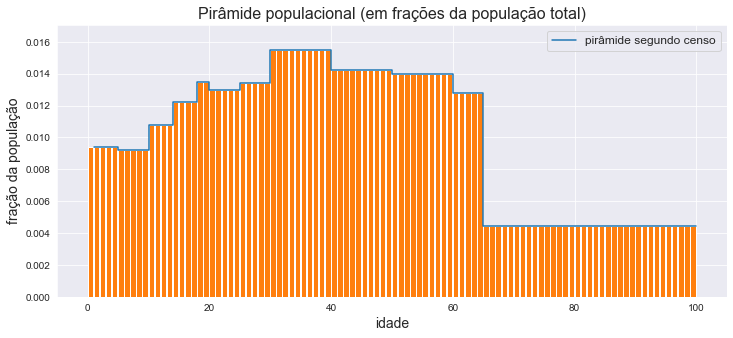

In [37]:
plt.figure(figsize=(12,5))
plt.bar(list(range(idade_max)), idades_fracoes, width=0.9, align = 'edge', color='tab:orange')
plt.step(list(range(1, idade_max+1)), idades_fracoes, label='pirâmide segundo censo')
plt.ylim([0,1.1*idades_fracoes.max()])
plt.xlabel('idade', fontsize=14)
plt.ylabel('fração da população', fontsize=14)
plt.title('Pirâmide populacional (em frações da população total)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por dez mil

In [38]:
pop_por_bloco = (landscan_rio/10000).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 297


#### Aloca população e residências

In [39]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 342 ms, sys: 11.2 ms, total: 353 ms
Wall time: 384 ms


#### Número de tamanhos de residências

In [40]:
num_tam_res = len(censo_residencial)

#### Gera idades

In [41]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 3.19 ms, sys: 145 µs, total: 3.34 ms
Wall time: 4.07 ms


#### Visualizando a pirâmide populacional obtida

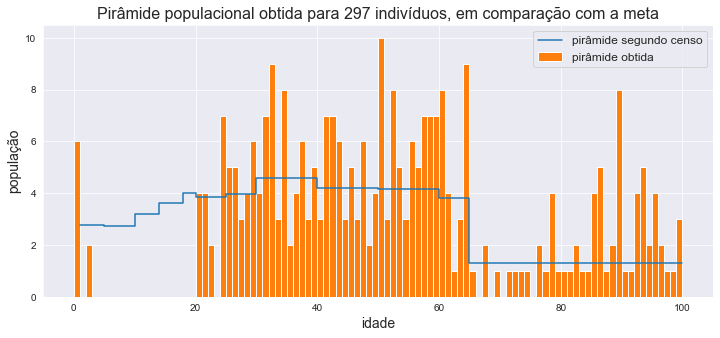

In [42]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por mil

In [43]:
pop_por_bloco = (landscan_rio/1000).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 6333


#### Aloca população e residências

In [44]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 260 ms, sys: 7.87 ms, total: 268 ms
Wall time: 294 ms


#### Gera idades

In [45]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 28 ms, sys: 911 µs, total: 28.9 ms
Wall time: 30.7 ms


#### Visualizando a pirâmide populacional obtida

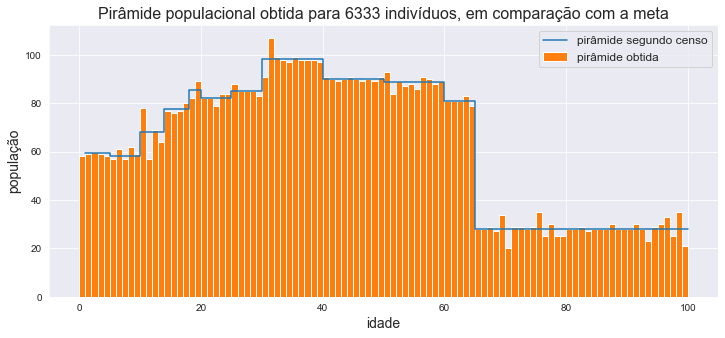

In [46]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por cem

In [47]:
pop_por_bloco = (landscan_rio/100).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 67973


#### Aloca população e residências

In [48]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 1.02 s, sys: 28.3 ms, total: 1.05 s
Wall time: 1.12 s


#### Gera idades

In [49]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 695 ms, sys: 8.53 ms, total: 704 ms
Wall time: 714 ms


#### Visualizando a pirâmide populacional obtida

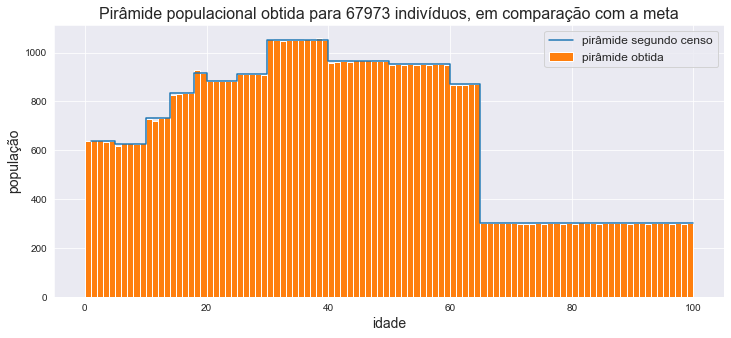

In [50]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### População um por dez

In [51]:
pop_por_bloco = (landscan_rio/10).astype(int)
num_pop = pop_por_bloco.sum()
print(f'População: {num_pop}')

População: 685131


#### Aloca população e residências

In [52]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 58.5 s, sys: 3.88 s, total: 1min 2s
Wall time: 1min 5s


#### Gera idades

In [53]:
%%time
pop_idades = episiming.cenarios.gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes)

CPU times: user 3min 33s, sys: 4.19 s, total: 3min 37s
Wall time: 3min 57s


#### Visualizando a pirâmide populacional obtida

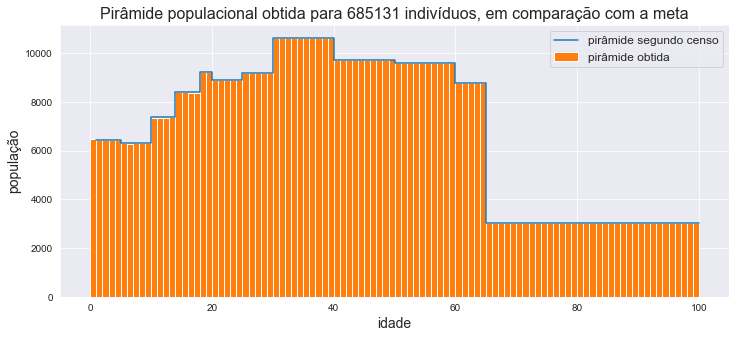

In [54]:
plt.figure(figsize=(12,5))
plt.hist(pop_idades, bins = list(range(idade_max+1)), color='tab:orange', label='pirâmide obtida')
plt.step(list(range(1, idade_max+1)), num_pop*idades_fracoes, label='pirâmide segundo censo')
plt.xlabel('idade', fontsize=14)
plt.ylabel('população', fontsize=14)
plt.title(f'Pirâmide populacional obtida para {num_pop} indivíduos, em comparação com a meta', fontsize=16)
plt.legend(fontsize=12)
plt.show()

<!--NAVIGATOR-->

---
[<- Modelo individual: incluindo a fase de exposição](21.00.Aula-Modelo_individual_infeccao_e_recuperacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário da cidade do Rio de Janeiro: rede de empresas ->](23.00.Aula-Cenario_Rio_Empresas.ipynb)